# FEATURE ENGINEERING NOTEBOOK
Felix A. Westphal
DLMDWME01

### Import

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

### Parameter

In [58]:
FILE_PATH_CLEANED_DATA = r"../data/processed/Cleaned_Input_Data.csv"
FILE_PATH_ENCODED_DATA = r"../data/processed/Encoded_Input_Data.csv"
FILE_PATH_EXTENDED_DATA = r"../data/processed/Extended_Input_Data.csv"
FILE_PATH_NORMALIZED_DATA = r"../data/processed/Normalized_Input_Data.csv"
FILE_PATH_BALANCED_DATA = r"../data/processed/Balanced_Input_Data.csv"
TIMESTAMP_FORMAT = "%Y-%m-%d %H:%M:%S"
TIMESTAMP_FORMAT_MINUTE = "%Y-%m-%d %H:%M"

### Load Data

In [59]:
cleaned_data = pd.read_csv(FILE_PATH_CLEANED_DATA, parse_dates=[0])                     # Load data files
encoded_data = pd.read_csv(FILE_PATH_ENCODED_DATA, parse_dates=[0])
print(f"Cleaned Data loaded from Excel: \n{cleaned_data.head()}")
print(f"Encoded Data loaded from Excel: \n{encoded_data.head()}")

Cleaned Data loaded from Excel: 
                 tmsp  country  amount  success         PSP  3D_secured  \
0 2019-01-01 00:01:11  Germany    89.0    False     UK_Card       False   
1 2019-01-01 00:01:17  Germany    89.0     True     UK_Card       False   
2 2019-01-01 00:02:49  Germany   238.0    False     UK_Card        True   
3 2019-01-01 00:03:13  Germany   238.0     True     UK_Card        True   
4 2019-01-01 00:04:33  Austria   124.0    False  Simplecard       False   

     card  
0    Visa  
1    Visa  
2  Diners  
3  Diners  
4  Diners  
Encoded Data loaded from Excel: 
                 tmsp  amount  success  3D_secured  Austria  Germany  \
0 2019-01-01 00:01:11    89.0    False       False    False     True   
1 2019-01-01 00:01:17    89.0     True       False    False     True   
2 2019-01-01 00:02:49   238.0    False        True    False     True   
3 2019-01-01 00:03:13   238.0     True        True    False     True   
4 2019-01-01 00:04:33   124.0    False       False 

### Number of Tries

In [60]:
print("========== CALCULATING NUMBER OF TRIES ==========")
tmp_data = cleaned_data.sort_values(by="tmsp")                                               # Sort the dataframe by timestamp
tmp_data["num_tries"] = 0                                                                  # Add new column
tmp_data["order_id"] = None

order_id = 0
for i in range(len(tmp_data)):
    if i > 0 \
    and tmp_data.iloc[i]["tmsp"].strftime(TIMESTAMP_FORMAT_MINUTE) == tmp_data.iloc[i-1]["tmsp"].strftime(TIMESTAMP_FORMAT_MINUTE) \
    and tmp_data.iloc[i]["country"] == tmp_data.iloc[i-1]["country"] \
    and tmp_data.iloc[i]["amount"] == tmp_data.iloc[i-1]["amount"]:
        tmp_data.at[i, "num_tries"] = tmp_data.iloc[i-1]["num_tries"] + 1
        tmp_data.at[i, 'order_id'] = order_id
    else:
        tmp_data.at[i, 'num_tries'] = 1
        order_id = order_id + 1
        tmp_data.at[i, 'order_id'] = order_id

# --- Add new columns to encoded data frame
extended_data = encoded_data
extended_data["num_tries"] = tmp_data["num_tries"]
extended_data["order_id"] = tmp_data["order_id"]

print(f"\n========== EXTENDED DATA FRAME ========== \n{extended_data.head()}")
extended_data.to_csv(FILE_PATH_EXTENDED_DATA, index=False)
print(f"Saved Extended Data Frame as .csv to: {FILE_PATH_EXTENDED_DATA}")

========== CALCULATING NUMBER OF TRIES ==========

========== EXTENDED DATA FRAME ========== 
                 tmsp  amount  success  3D_secured  Austria  Germany  \
0 2019-01-01 00:01:11    89.0    False       False    False     True   
1 2019-01-01 00:01:17    89.0     True       False    False     True   
2 2019-01-01 00:02:49   238.0    False        True    False     True   
3 2019-01-01 00:03:13   238.0     True        True    False     True   
4 2019-01-01 00:04:33   124.0    False       False     True    False   

   Switzerland  Goldcard  Moneycard  Simplecard  UK_Card  Diners  Master  \
0        False     False      False       False     True   False   False   
1        False     False      False       False     True   False   False   
2        False     False      False       False     True    True   False   
3        False     False      False       False     True    True   False   
4        False     False      False        True    False    True   False   

    Visa  num_tr

### Number of Tries vs. Success

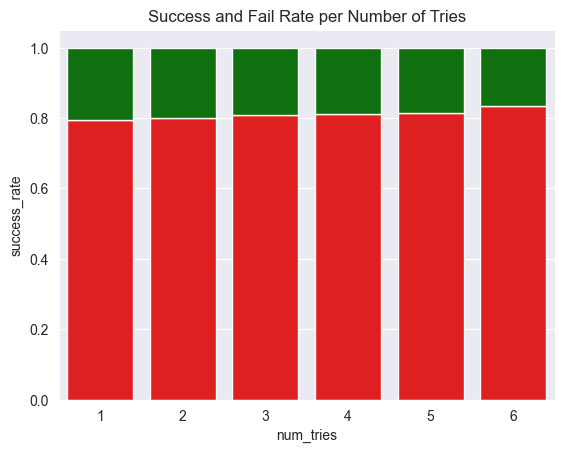

In [61]:
# --- Success Rate Calculation
tries_success = extended_data.groupby(['num_tries', 'success']).size().reset_index(name='count')                                                                           # Group the input data by num_tries and success
success_rate_tries = tries_success.groupby('num_tries').apply(lambda x: x[x['success'] == True]['count'].sum() / x['count'].sum()).reset_index(name='success_rate')   # Calculate the success rate per num_tries
failed_rate_tries = tries_success.groupby('num_tries').apply(lambda x: x[x['success'] == False]['count'].sum() / x['count'].sum()).reset_index(name='failed_rate')    # Calculate the fail rate per num_tries
rates_tries = pd.merge(success_rate_tries, failed_rate_tries, on='num_tries')                                                                                       # Merge fail and pass

# --- Result Plots
ax = sns.barplot(x='num_tries', y='failed_rate', data=rates_tries, color='red')
sns.barplot(x='num_tries', y='success_rate', data=rates_tries, color='green', ax=ax, bottom=rates_tries['failed_rate'])
plt.title('Success and Fail Rate per Number of Tries')
plt.show()

### Dataset Normalization
Normalization is a process by which we scale values to be between specified limits, usually -1 to 1 or 0 to 1. This process is important because our machine learning models are heavily affected by differences in number size.
The difference between 200 and 1 will cause massive inaccuracies in our model compared to the difference between 1 and 0.1.

In [62]:
norm_data = extended_data
scaler = MinMaxScaler()
scaler.fit(norm_data['amount'].values.reshape(-1, 1))
norm_data['amount'] = scaler.fit_transform(norm_data['amount'].values.reshape(-1, 1))
print(f"Maximus of Column \"amount\":{scaler.data_max_}")
print(norm_data)

print(f"\n========== NORMALIZE DATA FRAME ========== \n{norm_data.head()}")
norm_data.to_csv(FILE_PATH_NORMALIZED_DATA, index=False)
print(f"Saved Normalized Data Frame as .csv to: {FILE_PATH_NORMALIZED_DATA}")

Maximus of Column "amount":[630.]
                     tmsp    amount  success  3D_secured  Austria  Germany  \
0     2019-01-01 00:01:11  0.133013    False       False    False     True   
1     2019-01-01 00:01:17  0.133013     True       False    False     True   
2     2019-01-01 00:02:49  0.371795    False        True    False     True   
3     2019-01-01 00:03:13  0.371795     True        True    False     True   
4     2019-01-01 00:04:33  0.189103    False       False     True    False   
...                   ...       ...      ...         ...      ...      ...   
50405 2019-02-28 23:45:39  0.655449    False       False    False    False   
50406 2019-02-28 23:46:48  0.136218    False       False     True    False   
50407 2019-02-28 23:47:04  0.136218    False       False     True    False   
50408 2019-02-28 23:47:36  0.136218    False       False     True    False   
50409 2019-02-28 23:48:19  0.136218     True       False     True    False   

       Switzerland  Goldcard 

### Dataset Balancing
 Building a model with that failed vs succeeded distribution is very difficult because our model will predict significantly more failed transactions since there is such an uneven distribution.
 Equalizing the number of failed and succeeded transactions: This will allow for better prediction since the model will be trained to expect failed and not failed with an equal chance since it is a binary outcome.

In [63]:
failed_transaction = norm_data[norm_data["success"] == False]
succeeded_transaction = norm_data[norm_data["success"] == True]
num_failed = len(failed_transaction.index)
num_succeeded = len(succeeded_transaction.index)
print("Number of failed transactions: " + str(num_failed))
print("Number of succeeded transactions: " + str(num_succeeded))

# --- Equalization of data between failed and succeeded transaction
failed_transaction = norm_data.loc[norm_data['success'] == False][:num_succeeded]            # Selecting randomly failed entries
equalized_df = pd.concat([succeeded_transaction, failed_transaction])
equalized_df = equalized_df.sample(frac = 1, random_state = 42)
failed_df = equalized_df[equalized_df['success'] == False]
succeeded_df = equalized_df[equalized_df['success'] == True]
num_failed = len(failed_df.index)
num_succeeded = len(succeeded_df.index)
print("Number of failed transactions after balancing: " + str(num_failed))
print("Number of succeeded transactions after balancing: " + str(num_succeeded))

print(f"\n========== BALANCED DATA FRAME ========== \n{equalized_df.head()}")
equalized_df.to_csv(FILE_PATH_BALANCED_DATA, index=False)
print(f"Saved Extended Data Frame as .csv to: {FILE_PATH_BALANCED_DATA}")

Number of failed transactions: 40182
Number of succeeded transactions: 10228
Number of failed transactions after balancing: 10228
Number of succeeded transactions after balancing: 10228

========== BALANCED DATA FRAME ========== 
                     tmsp    amount  success  3D_secured  Austria  Germany  \
9675  2019-01-10 16:10:29  0.394231    False       False    False    False   
13935 2019-01-15 22:32:40  0.081731     True       False    False    False   
10939 2019-01-12 02:22:27  0.424679    False       False    False     True   
5635  2019-01-06 06:55:16  0.290064     True       False     True    False   
11839 2019-01-13 09:52:50  0.354167    False       False    False     True   

       Switzerland  Goldcard  Moneycard  Simplecard  UK_Card  Diners  Master  \
9675          True     False      False       False     True    True   False   
13935         True     False      False        True    False   False   False   
10939        False     False      False       False     True 